# Value at Risk

## 1. Reksa Dana

In [3]:
import pandas as pd
import numpy as np

# =========================================================
# 1. BACA DATA UNTUK SATU KELAS ASET
# =========================================================

file_path = "PL_RD.xlsx"   # ganti jika nama file berbeda
df = pd.read_excel(file_path)

# Pastikan kolom Date terbaca sebagai datetime (kalau ada)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# Nama kolom return/PL yang akan dihitung (SATU kelas aset)
ASSET_COL = "PL_RD"       # <-- GANTI sesuai nama kolom di Excel

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

# =========================================================
# 2. HITUNG HISTORICAL VaR & ES UNTUK SATU KELAS ASET
# =========================================================

series = df[ASSET_COL].dropna()  # buang NaN
n = len(series)
if n < 5:
    raise ValueError(f"Data untuk {ASSET_COL} terlalu sedikit (hanya {n} observasi).")

mu = series.mean()
sigma = series.std(ddof=1)

# Level confidence
alpha_95 = 0.95
alpha_99 = 0.99

# ============================
# Historical VaR (berbasis return PL)
# ============================
# Di sini PL (misal -0.05 = -5%) → quantile kiri = return terburuk
q05 = series.quantile(1 - alpha_95)  # 5% kiri
q01 = series.quantile(1 - alpha_99)  # 1% kiri

# VaR sebagai angka positif (kerugian)
var95 = -q05
var99 = -q01

# ============================
# Expected Shortfall (ES) - berbasis loss
# ============================
# Definisikan loss = -return (jadi kalau return -5%, loss +5%)
losses = -series

# Kuantil loss di kanan (95% & 99%)
loss_q95 = np.quantile(losses, alpha_95)
loss_q99 = np.quantile(losses, alpha_99)

# ES = rata-rata loss di atas threshold VaR (loss_q)
es95 = losses[losses >= loss_q95].mean()
es99 = losses[losses >= loss_q99].mean()

# Simpan hasil utama
result = {
    "n_obs": n,
    "mean_return": mu,
    "stdev_return": sigma,
    "hist_VaR95_pct": var95,        # desimal (mis. 0.0563 = 5.63%)
    "hist_VaR99_pct": var99,
    "hist_ES95_loss_pct": es95,     # ES dalam loss (positif)
    "hist_ES99_loss_pct": es99,
}

# =========================================================
# 3. HITUNG EL, UL, TAIL LOSS UNTUK SATU KELAS ASET
# =========================================================

EL = -result["mean_return"]           # Expected Loss = -mean
VaR95 = result["hist_VaR95_pct"]
VaR99 = result["hist_VaR99_pct"]
ES95 = result["hist_ES95_loss_pct"]
ES99 = result["hist_ES99_loss_pct"]

ul_result = {
    "EL_pct": EL,
    "UL95_pct": VaR95 - EL,          # UL95 = VaR95 - EL
    "UL99_pct": VaR99 - EL,          # UL99 = VaR99 - EL
    "Tail95_pct": ES95 - VaR95,      # Tail gap di atas VaR95
    "Tail99_pct": ES99 - VaR99,      # Tail gap di atas VaR99
}

# =========================================================
# 4. SUSUN TABEL DALAM %
# =========================================================

table = {
    "n_obs": result["n_obs"],
    "mean": result["mean_return"],
    "stdev": result["stdev_return"],
    "VaR95": result["hist_VaR95_pct"],
    "VaR99": result["hist_VaR99_pct"],
    "ES95": result["hist_ES95_loss_pct"],
    "ES99": result["hist_ES99_loss_pct"],
    "EL": ul_result["EL_pct"],
    "UL95": ul_result["UL95_pct"],
    "UL99": ul_result["UL99_pct"],
    "Tail95_gap": ul_result["Tail95_pct"],
    "Tail99_gap": ul_result["Tail99_pct"],
}

summary_df = pd.DataFrame([table], index=[ASSET_COL]).round(2)

# =========================================================
# 5. FORMAT ANGKA RUPIAH (tanpa scientific notation)
# =========================================================

pd.options.display.float_format = '{:,.0f}'.format  # global formatting

print("\n=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===")
print(summary_df)


=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===
       n_obs          mean          stdev          VaR95           VaR99  \
PL_RD    343 1,439,474,885 47,509,931,492 77,272,436,887 125,119,937,766   

                 ES95            ES99             EL           UL95  \
PL_RD 107,947,373,220 145,357,418,405 -1,439,474,885 78,711,911,772   

                 UL99     Tail95_gap     Tail99_gap  
PL_RD 126,559,412,651 30,674,936,334 20,237,480,639  


Graph

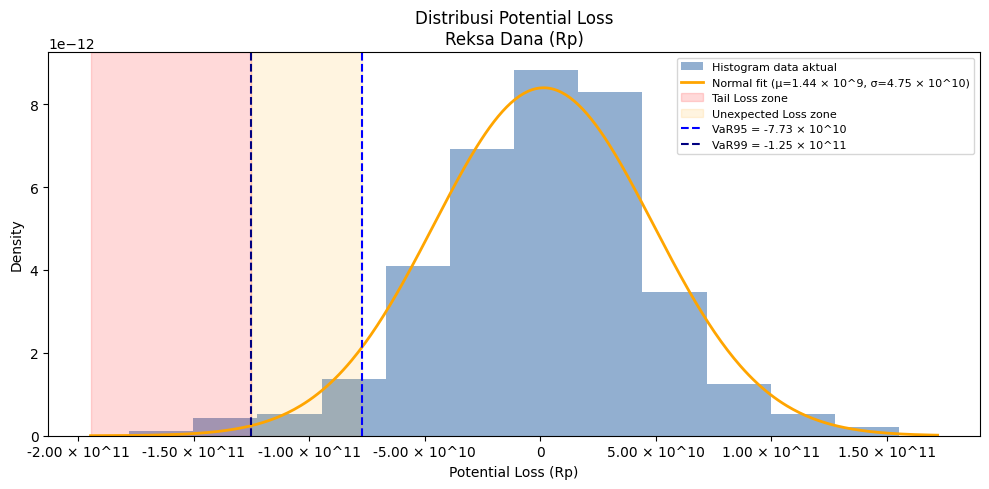

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from scipy.stats import norm

# =========================================================
# 1. INPUT
# =========================================================

file_path = "PL_RD.xlsx"
df = pd.read_excel(file_path)

ASSET_COL = "PL_RD"
ASSET_NAME = "Reksa Dana"

risk_threshold = {
    "appetite":  -3e9,   # contoh angka real (Rp)
    "tolerance": -5e9,
    "limit":     -2e9,
}

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan.")

# =========================================================
# 2. COMPUTATION
# =========================================================

series = df[ASSET_COL].dropna()
mu = series.mean()
sigma = series.std(ddof=1)

# Historical VaR
q05 = series.quantile(0.05)
q01 = series.quantile(0.01)

# thresholds
lim = risk_threshold["limit"]
app = risk_threshold["appetite"]
tol = risk_threshold["tolerance"]

# x-range
x_min = min(series.min(), tol)
x_max = max(series.max(), 0)
x_range = x_max - x_min
x = np.linspace(x_min - 0.05*x_range, x_max + 0.05*x_range, 400)
y = norm.pdf(x, mu, sigma)

# =========================================================
# 3. CUSTOM ENGINEERING FORMATTER
# =========================================================

def sci_fmt(x):
    """
    Format angka besar menjadi: 'a × 10^b'
    Example: 3510000000 → 3.51 × 10⁹
    """
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return f"{coeff:.2f} × 10^{exponent}"

fmt = FuncFormatter(lambda val, pos: sci_fmt(val))

# =========================================================
# 4. PLOT
# =========================================================

fig, ax = plt.subplots(figsize=(10,5))

# Histogram
ax.hist(series, bins=12, density=True,
        alpha=0.5, color="#2661a2",
        label="Histogram data aktual")

# Normal fit line
ax.plot(x, y,
        linewidth=2, color="orange",
        label=f"Normal fit (μ={sci_fmt(mu)}, σ={sci_fmt(sigma)})")

# Shading VaR zones
ax.axvspan(x_min - 0.05*x_range, q01,
           alpha=0.15, color="red", label="Tail Loss zone")
ax.axvspan(q01, q05,
           alpha=0.12, color="orange", label="Unexpected Loss zone")

# VaR lines
ax.axvline(q05, linestyle="--", linewidth=1.5, color="blue",
           label=f"VaR95 = {sci_fmt(q05)}")
ax.axvline(q01, linestyle="--", linewidth=1.5, color="navy",
           label=f"VaR99 = {sci_fmt(q01)}")

# Threshold lines
# ax.axvline(lim, linestyle=":", linewidth=1.5, color="green",
#            label=f"Limit = {sci_fmt(lim)}")
# ax.axvline(app, linestyle=":", linewidth=1.5, color="gold",
#            label=f"Appetite = {sci_fmt(app)}")
# ax.axvline(tol, linestyle=":", linewidth=1.5, color="red",
#            label=f"Tolerance = {sci_fmt(tol)}")

# Use engineering-style formatting on x-axis
ax.xaxis.set_major_formatter(fmt)

ax.set_title(f"Distribusi Potential Loss\n{ASSET_NAME} (Rp)")
ax.set_xlabel("Potential Loss (Rp)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## 2. Saham

In [5]:
import pandas as pd
import numpy as np

# =========================================================
# 1. BACA DATA UNTUK SATU KELAS ASET
# =========================================================

file_path = "PL_saham.xlsx"   # ganti jika nama file berbeda
df = pd.read_excel(file_path)

# Pastikan kolom Date terbaca sebagai datetime (kalau ada)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# Nama kolom return/PL yang akan dihitung (SATU kelas aset)
ASSET_COL = "PL_saham"       # <-- GANTI sesuai nama kolom di Excel

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

# =========================================================
# 2. HITUNG HISTORICAL VaR & ES UNTUK SATU KELAS ASET
# =========================================================

series = df[ASSET_COL].dropna()  # buang NaN
n = len(series)
if n < 5:
    raise ValueError(f"Data untuk {ASSET_COL} terlalu sedikit (hanya {n} observasi).")

mu = series.mean()
sigma = series.std(ddof=1)

# Level confidence
alpha_95 = 0.95
alpha_99 = 0.99

# ============================
# Historical VaR (berbasis return PL)
# ============================
# Di sini PL (misal -0.05 = -5%) → quantile kiri = return terburuk
q05 = series.quantile(1 - alpha_95)  # 5% kiri
q01 = series.quantile(1 - alpha_99)  # 1% kiri

# VaR sebagai angka positif (kerugian)
var95 = -q05
var99 = -q01

# ============================
# Expected Shortfall (ES) - berbasis loss
# ============================
# Definisikan loss = -return (jadi kalau return -5%, loss +5%)
losses = -series

# Kuantil loss di kanan (95% & 99%)
loss_q95 = np.quantile(losses, alpha_95)
loss_q99 = np.quantile(losses, alpha_99)

# ES = rata-rata loss di atas threshold VaR (loss_q)
es95 = losses[losses >= loss_q95].mean()
es99 = losses[losses >= loss_q99].mean()

# Simpan hasil utama
result = {
    "n_obs": n,
    "mean_return": mu,
    "stdev_return": sigma,
    "hist_VaR95_pct": var95,        # desimal (mis. 0.0563 = 5.63%)
    "hist_VaR99_pct": var99,
    "hist_ES95_loss_pct": es95,     # ES dalam loss (positif)
    "hist_ES99_loss_pct": es99,
}

# =========================================================
# 3. HITUNG EL, UL, TAIL LOSS UNTUK SATU KELAS ASET
# =========================================================

EL = -result["mean_return"]           # Expected Loss = -mean
VaR95 = result["hist_VaR95_pct"]
VaR99 = result["hist_VaR99_pct"]
ES95 = result["hist_ES95_loss_pct"]
ES99 = result["hist_ES99_loss_pct"]

ul_result = {
    "EL_pct": EL,
    "UL95_pct": VaR95 - EL,          # UL95 = VaR95 - EL
    "UL99_pct": VaR99 - EL,          # UL99 = VaR99 - EL
    "Tail95_pct": ES95 - VaR95,      # Tail gap di atas VaR95
    "Tail99_pct": ES99 - VaR99,      # Tail gap di atas VaR99
}

# =========================================================
# 4. SUSUN TABEL DALAM %
# =========================================================

table = {
    "n_obs": result["n_obs"],
    "mean": result["mean_return"],
    "stdev": result["stdev_return"],
    "VaR95": result["hist_VaR95_pct"],
    "VaR99": result["hist_VaR99_pct"],
    "ES95": result["hist_ES95_loss_pct"],
    "ES99": result["hist_ES99_loss_pct"],
    "EL": ul_result["EL_pct"],
    "UL95": ul_result["UL95_pct"],
    "UL99": ul_result["UL99_pct"],
    "Tail95_gap": ul_result["Tail95_pct"],
    "Tail99_gap": ul_result["Tail99_pct"],
}

summary_df = pd.DataFrame([table], index=[ASSET_COL]).round(2)

# =========================================================
# 5. FORMAT ANGKA RUPIAH (tanpa scientific notation)
# =========================================================

pd.options.display.float_format = '{:,.0f}'.format  # global formatting

print("\n=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===")
print(summary_df)


=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===
          n_obs         mean         stdev         VaR95          VaR99  \
PL_saham    258 -200,168,370 4,059,504,770 6,723,975,998 10,853,204,271   

                  ES95           ES99          EL          UL95  \
PL_saham 9,638,757,363 12,159,049,955 200,168,370 6,523,807,628   

                   UL99    Tail95_gap    Tail99_gap  
PL_saham 10,653,035,901 2,914,781,365 1,305,845,684  


Graph

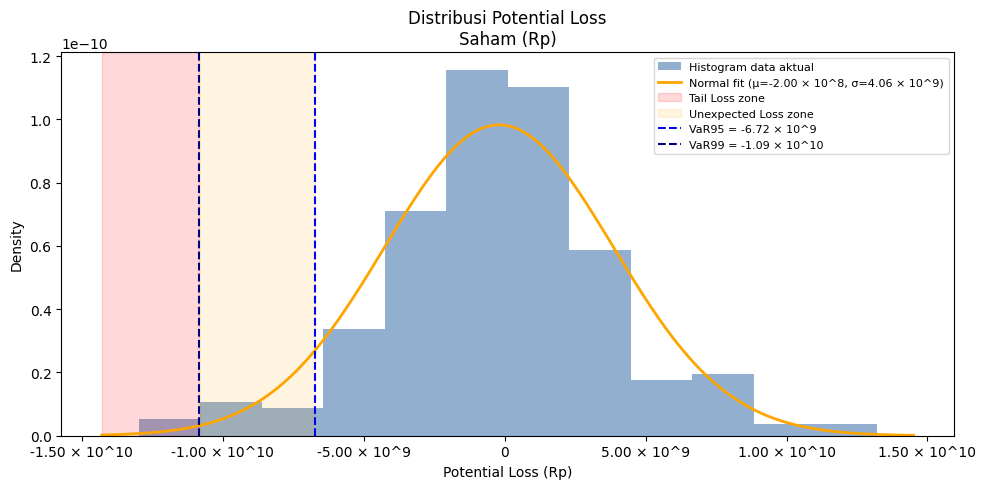

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from scipy.stats import norm

# =========================================================
# 1. INPUT
# =========================================================

file_path = "PL_saham.xlsx"
df = pd.read_excel(file_path)

ASSET_COL = "PL_saham"
ASSET_NAME = "Saham"

risk_threshold = {
    "appetite":  -3e9,   # contoh angka real (Rp)
    "tolerance": -5e9,
    "limit":     -2e9,
}

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan.")

# =========================================================
# 2. COMPUTATION
# =========================================================

series = df[ASSET_COL].dropna()
mu = series.mean()
sigma = series.std(ddof=1)

# Historical VaR
q05 = series.quantile(0.05)
q01 = series.quantile(0.01)

# thresholds
lim = risk_threshold["limit"]
app = risk_threshold["appetite"]
tol = risk_threshold["tolerance"]

# x-range
x_min = min(series.min(), tol)
x_max = max(series.max(), 0)
x_range = x_max - x_min
x = np.linspace(x_min - 0.05*x_range, x_max + 0.05*x_range, 400)
y = norm.pdf(x, mu, sigma)

# =========================================================
# 3. CUSTOM ENGINEERING FORMATTER
# =========================================================

def sci_fmt(x):
    """
    Format angka besar menjadi: 'a × 10^b'
    Example: 3510000000 → 3.51 × 10⁹
    """
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return f"{coeff:.2f} × 10^{exponent}"

fmt = FuncFormatter(lambda val, pos: sci_fmt(val))

# =========================================================
# 4. PLOT
# =========================================================

fig, ax = plt.subplots(figsize=(10,5))

# Histogram
ax.hist(series, bins=12, density=True,
        alpha=0.5, color="#2661a2",
        label="Histogram data aktual")

# Normal fit line
ax.plot(x, y,
        linewidth=2, color="orange",
        label=f"Normal fit (μ={sci_fmt(mu)}, σ={sci_fmt(sigma)})")

# Shading VaR zones
ax.axvspan(x_min - 0.05*x_range, q01,
           alpha=0.15, color="red", label="Tail Loss zone")
ax.axvspan(q01, q05,
           alpha=0.12, color="orange", label="Unexpected Loss zone")

# VaR lines
ax.axvline(q05, linestyle="--", linewidth=1.5, color="blue",
           label=f"VaR95 = {sci_fmt(q05)}")
ax.axvline(q01, linestyle="--", linewidth=1.5, color="navy",
           label=f"VaR99 = {sci_fmt(q01)}")

# Threshold lines
# ax.axvline(lim, linestyle=":", linewidth=1.5, color="green",
#            label=f"Limit = {sci_fmt(lim)}")
# ax.axvline(app, linestyle=":", linewidth=1.5, color="gold",
#            label=f"Appetite = {sci_fmt(app)}")
# ax.axvline(tol, linestyle=":", linewidth=1.5, color="red",
#            label=f"Tolerance = {sci_fmt(tol)}")

# Use engineering-style formatting on x-axis
ax.xaxis.set_major_formatter(fmt)

ax.set_title(f"Distribusi Potential Loss\n{ASSET_NAME} (Rp)")
ax.set_xlabel("Potential Loss (Rp)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## 3.1 Obligasi Korporasi

In [8]:
import pandas as pd
import numpy as np

# =========================================================
# 1. BACA DATA UNTUK SATU KELAS ASET
# =========================================================

file_path = "PL_CorpBond.xlsx"   # ganti jika nama file berbeda
df = pd.read_excel(file_path)

# Pastikan kolom Date terbaca sebagai datetime (kalau ada)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# Nama kolom return/PL yang akan dihitung (SATU kelas aset)
ASSET_COL = "PL_CorpBond"       # <-- GANTI sesuai nama kolom di Excel

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

# =========================================================
# 2. HITUNG HISTORICAL VaR & ES UNTUK SATU KELAS ASET
# =========================================================

series = df[ASSET_COL].dropna()  # buang NaN
n = len(series)
if n < 5:
    raise ValueError(f"Data untuk {ASSET_COL} terlalu sedikit (hanya {n} observasi).")

mu = series.mean()
sigma = series.std(ddof=1)

# Level confidence
alpha_95 = 0.95
alpha_99 = 0.99

# ============================
# Historical VaR (berbasis return PL)
# ============================
# Di sini PL (misal -0.05 = -5%) → quantile kiri = return terburuk
q05 = series.quantile(1 - alpha_95)  # 5% kiri
q01 = series.quantile(1 - alpha_99)  # 1% kiri

# VaR sebagai angka positif (kerugian)
var95 = -q05
var99 = -q01

# ============================
# Expected Shortfall (ES) - berbasis loss
# ============================
# Definisikan loss = -return (jadi kalau return -5%, loss +5%)
losses = -series

# Kuantil loss di kanan (95% & 99%)
loss_q95 = np.quantile(losses, alpha_95)
loss_q99 = np.quantile(losses, alpha_99)

# ES = rata-rata loss di atas threshold VaR (loss_q)
es95 = losses[losses >= loss_q95].mean()
es99 = losses[losses >= loss_q99].mean()

# Simpan hasil utama
result = {
    "n_obs": n,
    "mean_return": mu,
    "stdev_return": sigma,
    "hist_VaR95_pct": var95,        # desimal (mis. 0.0563 = 5.63%)
    "hist_VaR99_pct": var99,
    "hist_ES95_loss_pct": es95,     # ES dalam loss (positif)
    "hist_ES99_loss_pct": es99,
}

# =========================================================
# 3. HITUNG EL, UL, TAIL LOSS UNTUK SATU KELAS ASET
# =========================================================

EL = -result["mean_return"]           # Expected Loss = -mean
VaR95 = result["hist_VaR95_pct"]
VaR99 = result["hist_VaR99_pct"]
ES95 = result["hist_ES95_loss_pct"]
ES99 = result["hist_ES99_loss_pct"]

ul_result = {
    "EL_pct": EL,
    "UL95_pct": VaR95 - EL,          # UL95 = VaR95 - EL
    "UL99_pct": VaR99 - EL,          # UL99 = VaR99 - EL
    "Tail95_pct": ES95 - VaR95,      # Tail gap di atas VaR95
    "Tail99_pct": ES99 - VaR99,      # Tail gap di atas VaR99
}

# =========================================================
# 4. SUSUN TABEL DALAM %
# =========================================================

table = {
    "n_obs": result["n_obs"],
    "mean": result["mean_return"],
    "stdev": result["stdev_return"],
    "VaR95": result["hist_VaR95_pct"],
    "VaR99": result["hist_VaR99_pct"],
    "ES95": result["hist_ES95_loss_pct"],
    "ES99": result["hist_ES99_loss_pct"],
    "EL": ul_result["EL_pct"],
    "UL95": ul_result["UL95_pct"],
    "UL99": ul_result["UL99_pct"],
    "Tail95_gap": ul_result["Tail95_pct"],
    "Tail99_gap": ul_result["Tail99_pct"],
}

summary_df = pd.DataFrame([table], index=[ASSET_COL]).round(2)

# =========================================================
# 5. FORMAT ANGKA RUPIAH (tanpa scientific notation)
# =========================================================

pd.options.display.float_format = '{:,.0f}'.format  # global formatting

print("\n=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===")
print(summary_df)


=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===
             n_obs         mean         stdev         VaR95          VaR99  \
PL_CorpBond    342 -209,088,658 5,013,090,516 8,300,955,484 15,889,476,046   

                      ES95           ES99          EL          UL95  \
PL_CorpBond 12,540,506,769 18,646,847,232 209,088,658 8,091,866,826   

                      UL99    Tail95_gap    Tail99_gap  
PL_CorpBond 15,680,387,388 4,239,551,285 2,757,371,186  


## Graph

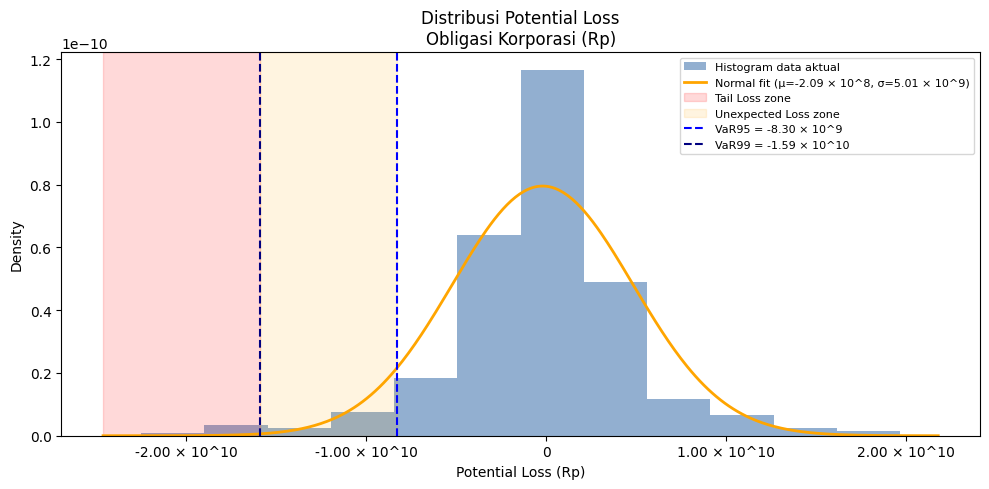

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from scipy.stats import norm

# =========================================================
# 1. INPUT
# =========================================================

file_path = "PL_CorpBond.xlsx"
df = pd.read_excel(file_path)

ASSET_COL = "PL_CorpBond"
ASSET_NAME = "Obligasi Korporasi"

risk_threshold = {
    "appetite":  -3e9,   # contoh angka real (Rp)
    "tolerance": -5e9,
    "limit":     -2e9,
}

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan.")

# =========================================================
# 2. COMPUTATION
# =========================================================

series = df[ASSET_COL].dropna()
mu = series.mean()
sigma = series.std(ddof=1)

# Historical VaR
q05 = series.quantile(0.05)
q01 = series.quantile(0.01)

# thresholds
lim = risk_threshold["limit"]
app = risk_threshold["appetite"]
tol = risk_threshold["tolerance"]

# x-range
x_min = min(series.min(), tol)
x_max = max(series.max(), 0)
x_range = x_max - x_min
x = np.linspace(x_min - 0.05*x_range, x_max + 0.05*x_range, 400)
y = norm.pdf(x, mu, sigma)

# =========================================================
# 3. CUSTOM ENGINEERING FORMATTER
# =========================================================

def sci_fmt(x):
    """
    Format angka besar menjadi: 'a × 10^b'
    Example: 3510000000 → 3.51 × 10⁹
    """
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return f"{coeff:.2f} × 10^{exponent}"

fmt = FuncFormatter(lambda val, pos: sci_fmt(val))

# =========================================================
# 4. PLOT
# =========================================================

fig, ax = plt.subplots(figsize=(10,5))

# Histogram
ax.hist(series, bins=12, density=True,
        alpha=0.5, color="#2661a2",
        label="Histogram data aktual")

# Normal fit line
ax.plot(x, y,
        linewidth=2, color="orange",
        label=f"Normal fit (μ={sci_fmt(mu)}, σ={sci_fmt(sigma)})")

# Shading VaR zones
ax.axvspan(x_min - 0.05*x_range, q01,
           alpha=0.15, color="red", label="Tail Loss zone")
ax.axvspan(q01, q05,
           alpha=0.12, color="orange", label="Unexpected Loss zone")

# VaR lines
ax.axvline(q05, linestyle="--", linewidth=1.5, color="blue",
           label=f"VaR95 = {sci_fmt(q05)}")
ax.axvline(q01, linestyle="--", linewidth=1.5, color="navy",
           label=f"VaR99 = {sci_fmt(q01)}")

# Threshold lines
# ax.axvline(lim, linestyle=":", linewidth=1.5, color="green",
#            label=f"Limit = {sci_fmt(lim)}")
# ax.axvline(app, linestyle=":", linewidth=1.5, color="gold",
#            label=f"Appetite = {sci_fmt(app)}")
# ax.axvline(tol, linestyle=":", linewidth=1.5, color="red",
#            label=f"Tolerance = {sci_fmt(tol)}")

# Use engineering-style formatting on x-axis
ax.xaxis.set_major_formatter(fmt)

ax.set_title(f"Distribusi Potential Loss\n{ASSET_NAME} (Rp)")
ax.set_xlabel("Potential Loss (Rp)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## 3.2 MTN

In [1]:
import pandas as pd
import numpy as np

# =========================================================
# 1. BACA DATA UNTUK SATU KELAS ASET
# =========================================================

file_path = "PL_MTN.xlsx"   # ganti jika nama file berbeda
df = pd.read_excel(file_path)

# Pastikan kolom Date terbaca sebagai datetime (kalau ada)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# Nama kolom return/PL yang akan dihitung (SATU kelas aset)
ASSET_COL = "PL_MTN"       # <-- GANTI sesuai nama kolom di Excel

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

# =========================================================
# 2. HITUNG HISTORICAL VaR & ES UNTUK SATU KELAS ASET
# =========================================================

series = df[ASSET_COL].dropna()  # buang NaN
n = len(series)
if n < 5:
    raise ValueError(f"Data untuk {ASSET_COL} terlalu sedikit (hanya {n} observasi).")

mu = series.mean()
sigma = series.std(ddof=1)

# Level confidence
alpha_95 = 0.95
alpha_99 = 0.99

# ============================
# Historical VaR (berbasis return PL)
# ============================
# Di sini PL (misal -0.05 = -5%) → quantile kiri = return terburuk
q05 = series.quantile(1 - alpha_95)  # 5% kiri
q01 = series.quantile(1 - alpha_99)  # 1% kiri

# VaR sebagai angka positif (kerugian)
var95 = -q05
var99 = -q01

# ============================
# Expected Shortfall (ES) - berbasis loss
# ============================
# Definisikan loss = -return (jadi kalau return -5%, loss +5%)
losses = -series

# Kuantil loss di kanan (95% & 99%)
loss_q95 = np.quantile(losses, alpha_95)
loss_q99 = np.quantile(losses, alpha_99)

# ES = rata-rata loss di atas threshold VaR (loss_q)
es95 = losses[losses >= loss_q95].mean()
es99 = losses[losses >= loss_q99].mean()

# Simpan hasil utama
result = {
    "n_obs": n,
    "mean_return": mu,
    "stdev_return": sigma,
    "hist_VaR95_pct": var95,        # desimal (mis. 0.0563 = 5.63%)
    "hist_VaR99_pct": var99,
    "hist_ES95_loss_pct": es95,     # ES dalam loss (positif)
    "hist_ES99_loss_pct": es99,
}

# =========================================================
# 3. HITUNG EL, UL, TAIL LOSS UNTUK SATU KELAS ASET
# =========================================================

EL = -result["mean_return"]           # Expected Loss = -mean
VaR95 = result["hist_VaR95_pct"]
VaR99 = result["hist_VaR99_pct"]
ES95 = result["hist_ES95_loss_pct"]
ES99 = result["hist_ES99_loss_pct"]

ul_result = {
    "EL_pct": EL,
    "UL95_pct": VaR95 - EL,          # UL95 = VaR95 - EL
    "UL99_pct": VaR99 - EL,          # UL99 = VaR99 - EL
    "Tail95_pct": ES95 - VaR95,      # Tail gap di atas VaR95
    "Tail99_pct": ES99 - VaR99,      # Tail gap di atas VaR99
}

# =========================================================
# 4. SUSUN TABEL DALAM %
# =========================================================

table = {
    "n_obs": result["n_obs"],
    "mean": result["mean_return"],
    "stdev": result["stdev_return"],
    "VaR95": result["hist_VaR95_pct"],
    "VaR99": result["hist_VaR99_pct"],
    "ES95": result["hist_ES95_loss_pct"],
    "ES99": result["hist_ES99_loss_pct"],
    "EL": ul_result["EL_pct"],
    "UL95": ul_result["UL95_pct"],
    "UL99": ul_result["UL99_pct"],
    "Tail95_gap": ul_result["Tail95_pct"],
    "Tail99_gap": ul_result["Tail99_pct"],
}

summary_df = pd.DataFrame([table], index=[ASSET_COL]).round(2)

# =========================================================
# 5. FORMAT ANGKA RUPIAH (tanpa scientific notation)
# =========================================================

pd.options.display.float_format = '{:,.0f}'.format  # global formatting

print("\n=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===")
print(summary_df)


=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per periode) ===
        n_obs       mean         stdev         VaR95         VaR99  \
PL_MTN    343 -9,875,238 2,139,260,228 3,112,159,297 6,377,896,802   

                ES95          ES99        EL          UL95          UL99  \
PL_MTN 5,261,508,045 9,241,834,228 9,875,238 3,102,284,060 6,368,021,564   

          Tail95_gap    Tail99_gap  
PL_MTN 2,149,348,747 2,863,937,426  


## Graph

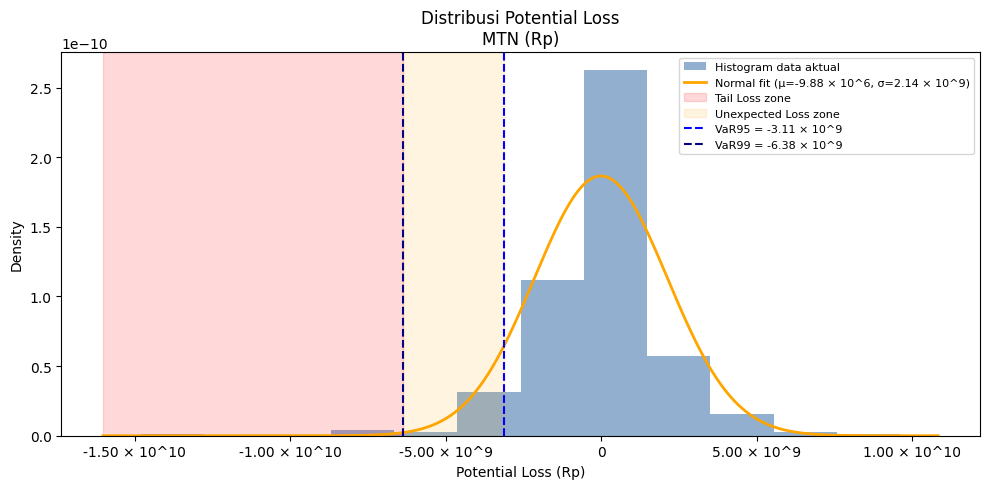

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from scipy.stats import norm

# =========================================================
# 1. INPUT
# =========================================================

file_path = "PL_MTN.xlsx"
df = pd.read_excel(file_path)

ASSET_COL = "PL_MTN"
ASSET_NAME = "MTN"

risk_threshold = {
    "appetite":  -3e9,   # contoh angka real (Rp)
    "tolerance": -5e9,
    "limit":     -2e9,
}

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan.")

# =========================================================
# 2. COMPUTATION
# =========================================================

series = df[ASSET_COL].dropna()
mu = series.mean()
sigma = series.std(ddof=1)

# Historical VaR
q05 = series.quantile(0.05)
q01 = series.quantile(0.01)

# thresholds
lim = risk_threshold["limit"]
app = risk_threshold["appetite"]
tol = risk_threshold["tolerance"]

# x-range
x_min = min(series.min(), tol)
x_max = max(series.max(), 0)
x_range = x_max - x_min
x = np.linspace(x_min - 0.05*x_range, x_max + 0.05*x_range, 400)
y = norm.pdf(x, mu, sigma)

# =========================================================
# 3. CUSTOM ENGINEERING FORMATTER
# =========================================================

def sci_fmt(x):
    """
    Format angka besar menjadi: 'a × 10^b'
    Example: 3510000000 → 3.51 × 10⁹
    """
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return f"{coeff:.2f} × 10^{exponent}"

fmt = FuncFormatter(lambda val, pos: sci_fmt(val))

# =========================================================
# 4. PLOT
# =========================================================

fig, ax = plt.subplots(figsize=(10,5))

# Histogram
ax.hist(series, bins=12, density=True,
        alpha=0.5, color="#2661a2",
        label="Histogram data aktual")

# Normal fit line
ax.plot(x, y,
        linewidth=2, color="orange",
        label=f"Normal fit (μ={sci_fmt(mu)}, σ={sci_fmt(sigma)})")

# Shading VaR zones
ax.axvspan(x_min - 0.05*x_range, q01,
           alpha=0.15, color="red", label="Tail Loss zone")
ax.axvspan(q01, q05,
           alpha=0.12, color="orange", label="Unexpected Loss zone")

# VaR lines
ax.axvline(q05, linestyle="--", linewidth=1.5, color="blue",
           label=f"VaR95 = {sci_fmt(q05)}")
ax.axvline(q01, linestyle="--", linewidth=1.5, color="navy",
           label=f"VaR99 = {sci_fmt(q01)}")

# Threshold lines
# ax.axvline(lim, linestyle=":", linewidth=1.5, color="green",
#            label=f"Limit = {sci_fmt(lim)}")
# ax.axvline(app, linestyle=":", linewidth=1.5, color="gold",
#            label=f"Appetite = {sci_fmt(app)}")
# ax.axvline(tol, linestyle=":", linewidth=1.5, color="red",
#            label=f"Tolerance = {sci_fmt(tol)}")

# Use engineering-style formatting on x-axis
ax.xaxis.set_major_formatter(fmt)

ax.set_title(f"Distribusi Potential Loss\n{ASSET_NAME} (Rp)")
ax.set_xlabel("Potential Loss (Rp)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()